In [1]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import scipy.stats as stats
import scipy.interpolate as inter
idx = pd.IndexSlice
pyo.init_notebook_mode()


root_folder = r"C:\Users\jamen\Google Drive\Everything\Results\P1 Model\OvenMeshIndy\\"
meshes = [["Mesh0",0,60,1],["Mesh1",0,60,1],["Mesh2",0,60,1],["Mesh3",0,60,1],["Mesh4",0,60,1],["Mesh5",0,60,1]] # name, first timestep, final timestep, timestep
areas = ["Food","Inlet","Outlet","Walls"] # prefix for each filename

In [2]:
# read all data into the workbook
alldata = pd.read_feather(root_folder+"alldata.feather")

In [3]:
# create a dataframe for all meshes containing the mean values on the food for each time step
food_means=alldata[alldata['area']=="Food"].groupby(["mesh","area","time"]).mean()
food_means.reset_index(inplace=True)

In [4]:
# plot average flux vs time for each mesh
px.line(food_means,x="time",y="flux",color="mesh")

The above plot is used to decide when the simulation has reached steady state, this is taken as 15 seconds and used to filter out the transient part of the data below

In [5]:
alldata = alldata[alldata['time']>15]
food_means = food_means[food_means['time']>15]

Plotting the number of elements in the mesh vs the average flux into the food over the steady state part of the simulation

In [6]:
mesh_mean = food_means.groupby(['mesh']).mean()
px.scatter(mesh_mean,x="elements",y="flux")

Create a new dataframe for contour plots of average flux over the steady state part of the sim onto the food target. 

In [7]:
contour_dfs = []
for mesh in meshes:
    mesh_df = alldata[(alldata['area']=="Food") & (alldata['mesh']==mesh[0])].groupby(['x','y','z']).mean()
    mesh_df.reset_index(inplace=True)
    mesh_df['mesh'] = mesh[0]
    contour_dfs.append(mesh_df)
contour_df = pd.concat(contour_dfs)
contour_df.reset_index(inplace=True)

Plot flux contour for each mesh

<IPython.core.display.Javascript object>


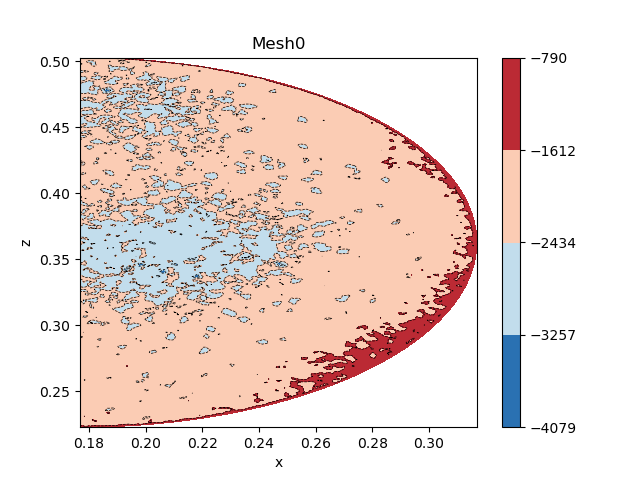

<IPython.core.display.Javascript object>


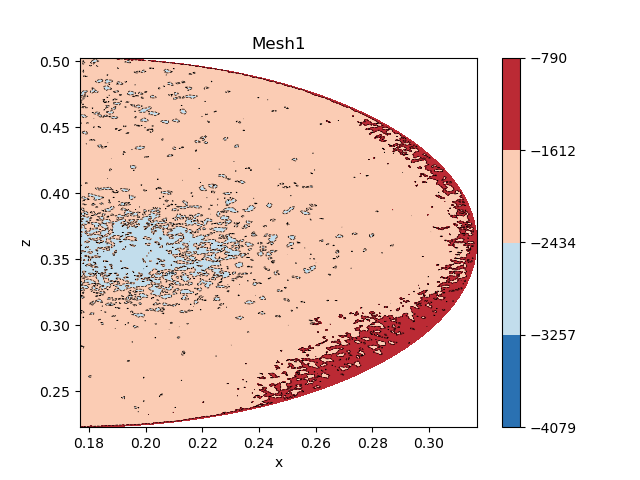

<IPython.core.display.Javascript object>


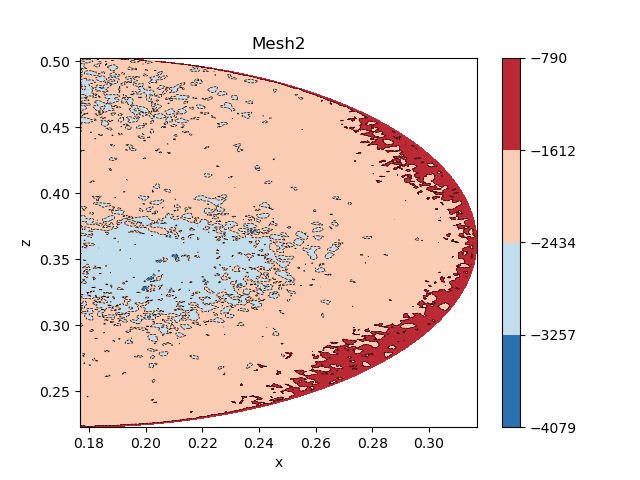

<IPython.core.display.Javascript object>


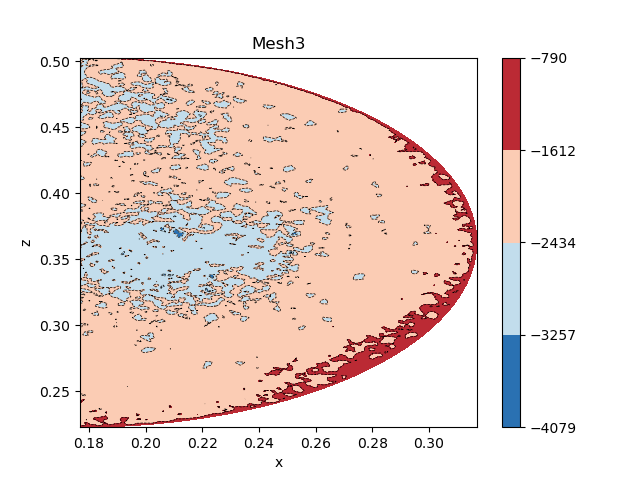

<IPython.core.display.Javascript object>


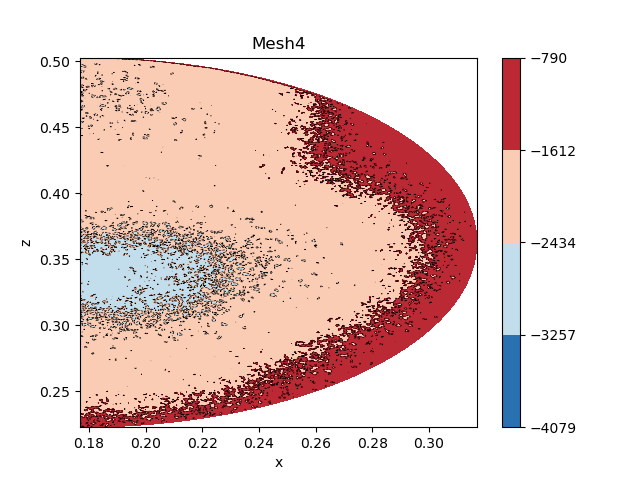

<IPython.core.display.Javascript object>


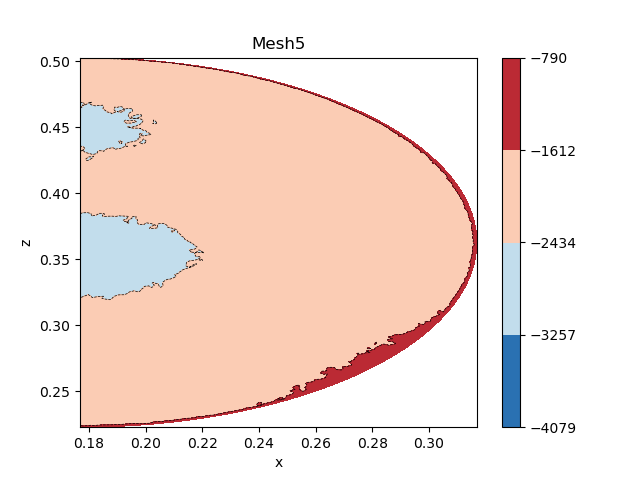

In [8]:
%matplotlib nbagg

figs = []

level_num = 5
levels = np.linspace(min(contour_df['flux']),max(contour_df['flux']),level_num)

for i in range(len(meshes)):
    figs.append(plt.subplots(nrows=1))
    fig, ax = figs[i]
    mesh = meshes[i]
    plot_df = contour_df[contour_df['mesh'] == mesh[0]]

    x = plot_df['x']
    y = plot_df['z']
    #z = df_combi[' Wall Heat Flux [ W m^-2 ]']
    z = plot_df['flux']

    ax.tricontour(x, y, z, linewidths=0.5, colors='k',levels=levels)
    cntr1 = ax.tricontourf(x, y, z, cmap="RdBu_r", levels=levels)
    fig.colorbar(cntr1, ax=ax)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_title(mesh[0])
plt.show()

To compare contours we need to put data on a common grid, to do this we interpolate the flux using scipy then project onto a common grid in a common dataframe. Creates a dataframe with x and z coordinates with the interpolated flux from each mesh. Two interpolators are used, a linear interpolator which makes the "RAW" columns and a smoothed cubic spline which creates the "SMOOTH" columns

In [9]:
resolution = 100 # number of x and y points
gridx = np.linspace(min(contour_df['x']),max(contour_df['x']),resolution)
gridz = np.linspace(min(contour_df['z']),max(contour_df['z']),resolution)

coords = []

for x in gridx:
    for z in gridz:
        coords.append([x,z])
        
interpolated_flux = pd.DataFrame({'x':[coord[0] for coord in coords],'z':[coord[1] for coord in coords]})

for i in range(len(meshes)): 
    mesh=meshes[i]
    calc_df = contour_df[contour_df['mesh'] == mesh[0]]
    cat_coord = list(zip(calc_df['x'],calc_df['z']))
    interpolator = inter.LinearNDInterpolator(cat_coord, calc_df['flux'],fill_value=np.NaN)
    interpolated_flux[mesh[0]] = interpolator(coords) 
interpolated_flux.dropna(axis=0, inplace=True)

Plotting the raw interpolated differences between the food fluxes

<IPython.core.display.Javascript object>


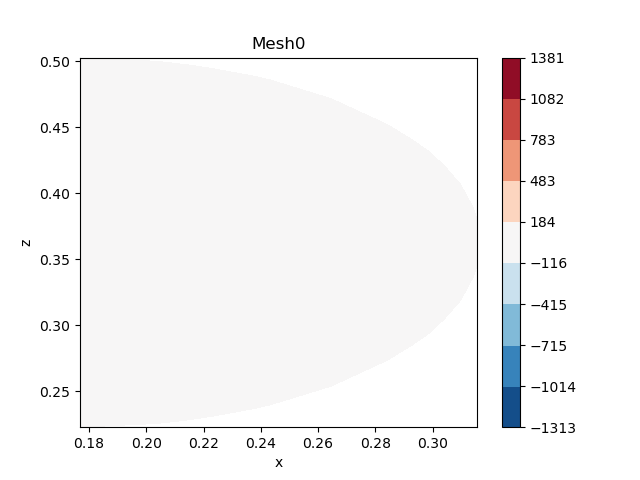

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: UserWarning:

No contour levels were found within the data range.



<IPython.core.display.Javascript object>


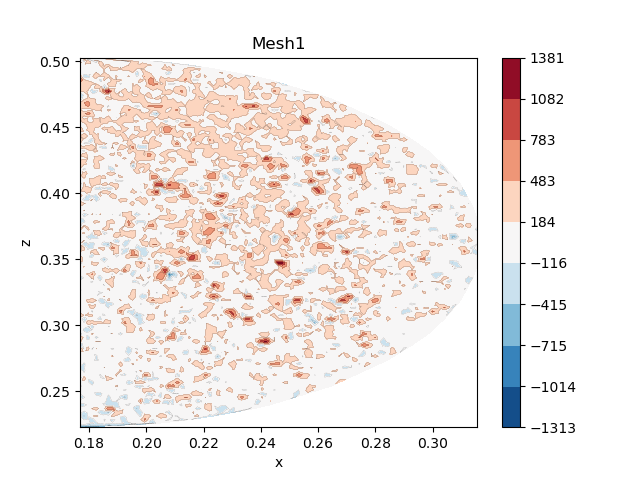

<IPython.core.display.Javascript object>


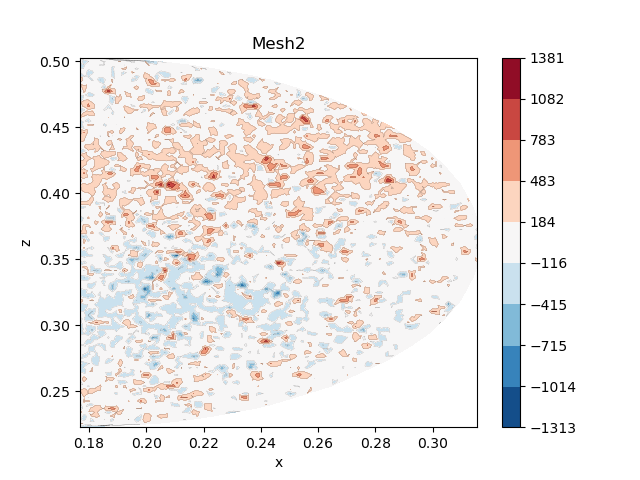

<IPython.core.display.Javascript object>


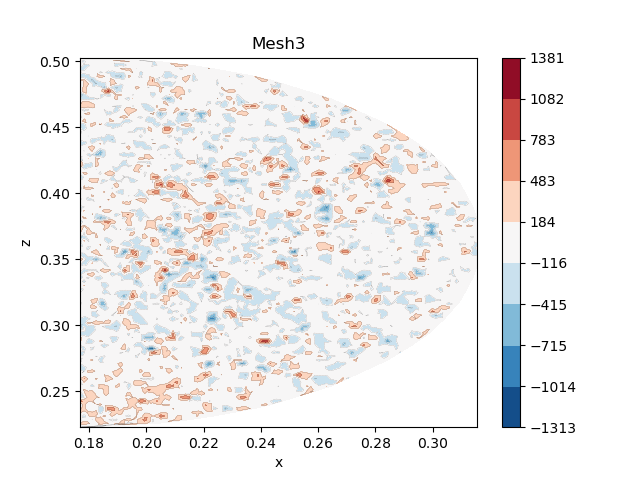

<IPython.core.display.Javascript object>


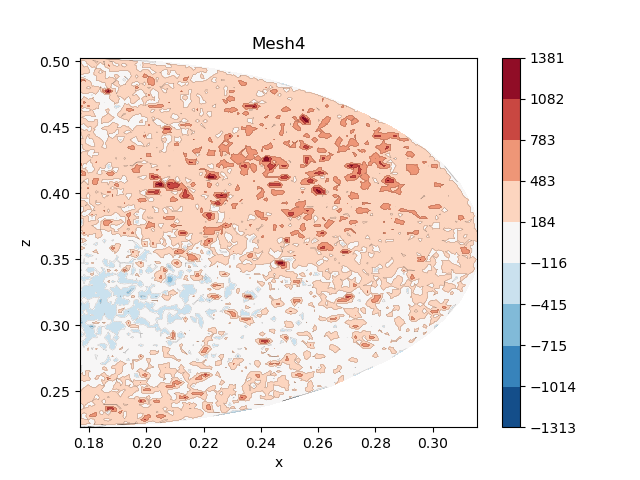

<IPython.core.display.Javascript object>


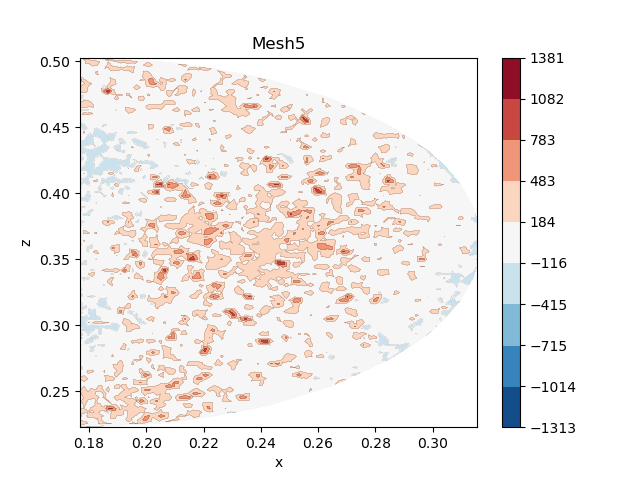

In [10]:
%matplotlib nbagg

level_num = 10

mins = []
maxs= []

for i in range(len(meshes)):
    mesh = meshes[i]
    interpolated_flux[mesh[0]+"diff"] = interpolated_flux[mesh[0]] - interpolated_flux["Mesh0"]
    mins.append(min(interpolated_flux[mesh[0]+"diff"]))
    maxs.append(max(interpolated_flux[mesh[0]+"diff"]))

levels = np.linspace(min(mins),max(maxs),level_num)
figs = []

for i in range(len(meshes)):
    mesh = meshes[i]
    figs.append(plt.subplots(nrows=1))
    fig, ax = figs[i]

    x = interpolated_flux['x']
    y = interpolated_flux['z']
    #z = df_combi[' Wall Heat Flux [ W m^-2 ]']
    z = interpolated_flux[mesh[0]+"diff"]

    ax.tricontour(x, y, z, linewidths=0.1, colors='k',levels=levels)
    cntr1 = ax.tricontourf(x, y, z, cmap="RdBu_r", levels=levels)
    fig.colorbar(cntr1, ax=ax)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_title(mesh[0])
plt.show()

The linearly interpolated data is a little too noisy to really draw conclusions from, therefore a smoothed data set was created using Scipy's inbuilt radial basis function Rbf. Smoothing can be controlled using the smoothing parameter, a new set of columns ("smoothed") are added to the dataframe and the base values and difference plotted.

Note that the Rbf is not applied to the raw data as it is too computationally expensive

<IPython.core.display.Javascript object>


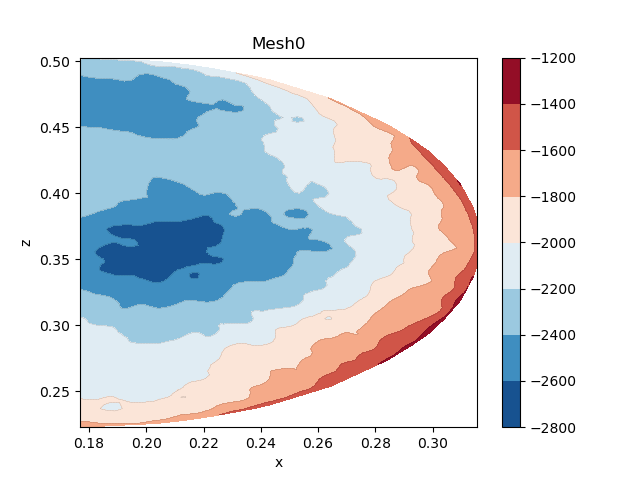

<IPython.core.display.Javascript object>


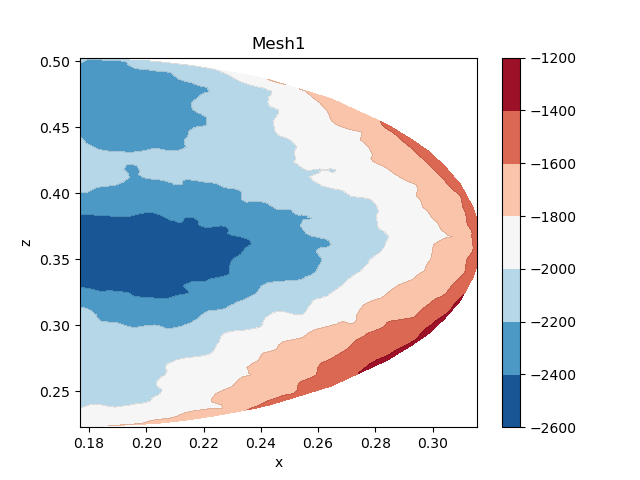

<IPython.core.display.Javascript object>


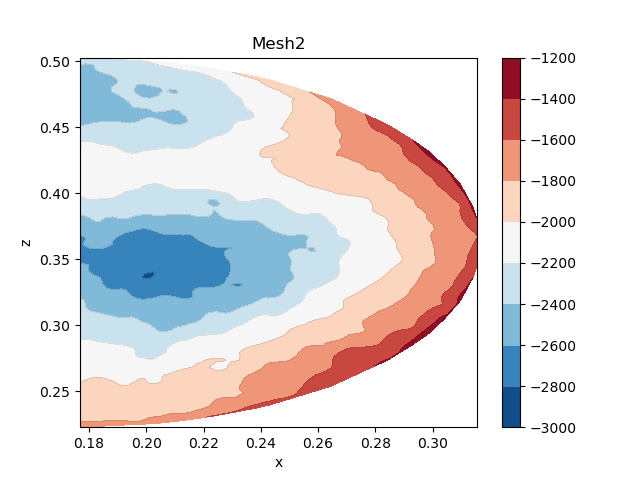

<IPython.core.display.Javascript object>


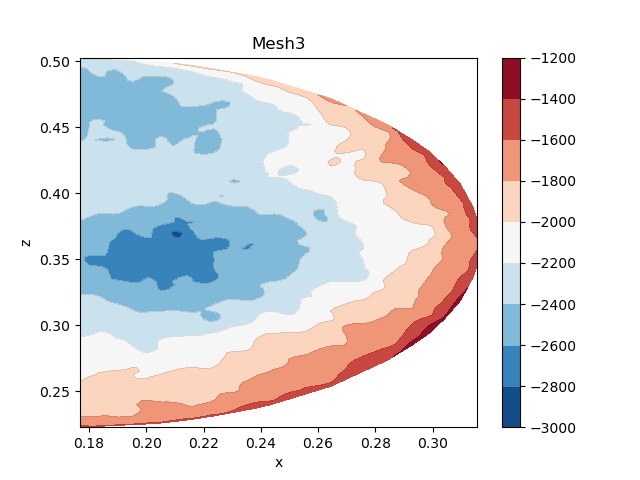

<IPython.core.display.Javascript object>


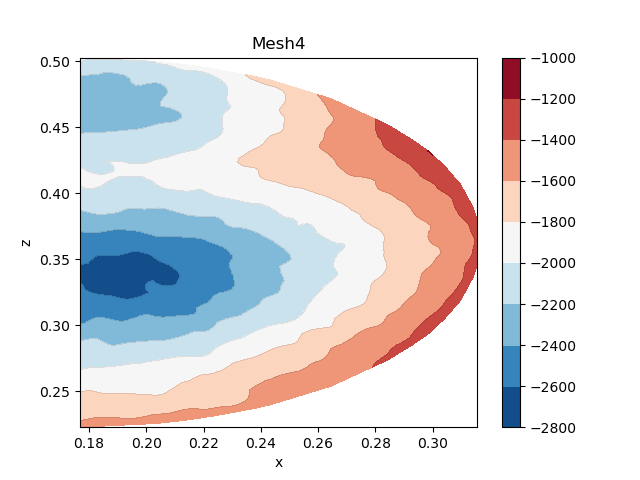

<IPython.core.display.Javascript object>


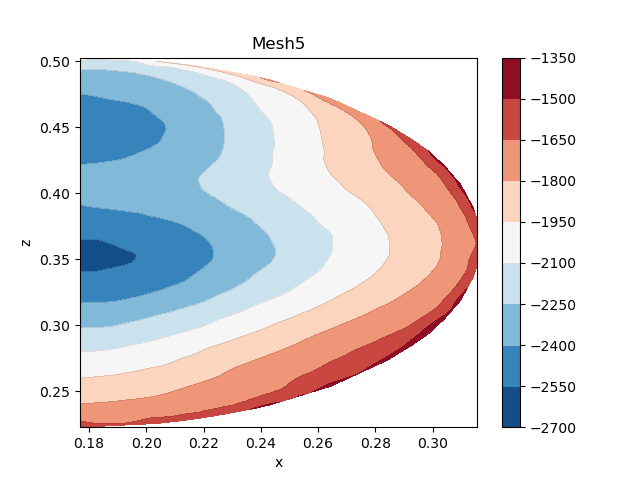

In [11]:
figs = []

smoothing = 10 # 1 appears a little low, 10 appears about right

for i in range(len(meshes)): 
    mesh=meshes[i]
    interpolator = inter.Rbf(interpolated_flux['x'],
                            interpolated_flux['z'],
                            interpolated_flux[mesh[0]],
                            smooth=smoothing)
    interpolated_flux[mesh[0]+"SMOOTHED"] = interpolator(interpolated_flux["x"],
                                                        interpolated_flux["z"])  


    figs.append(plt.subplots(nrows=1))
    fig, ax = figs[i]

    x = interpolated_flux['x']
    y = interpolated_flux['z']
    #z = df_combi[' Wall Heat Flux [ W m^-2 ]']
    z = interpolated_flux[mesh[0]+"SMOOTHED"]

    ax.tricontour(x, y, z, linewidths=0.1, colors='k')
    cntr1 = ax.tricontourf(x, y, z, cmap="RdBu_r")
    fig.colorbar(cntr1, ax=ax)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_title(mesh[0])
plt.show()

<IPython.core.display.Javascript object>


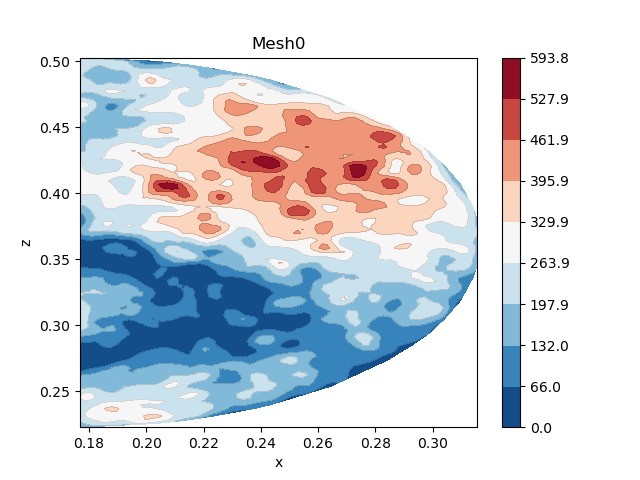

<IPython.core.display.Javascript object>


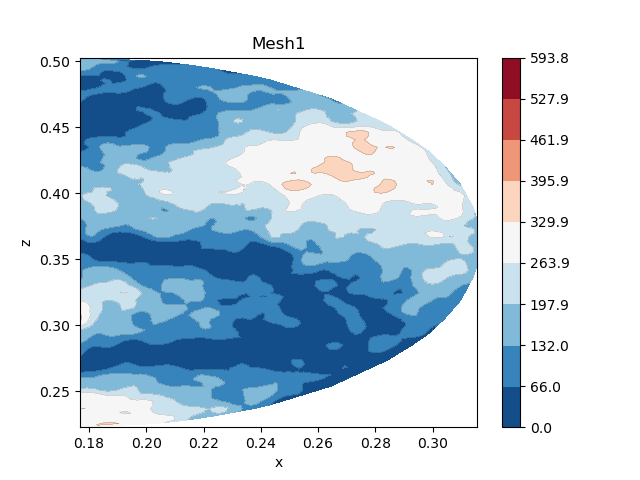

<IPython.core.display.Javascript object>


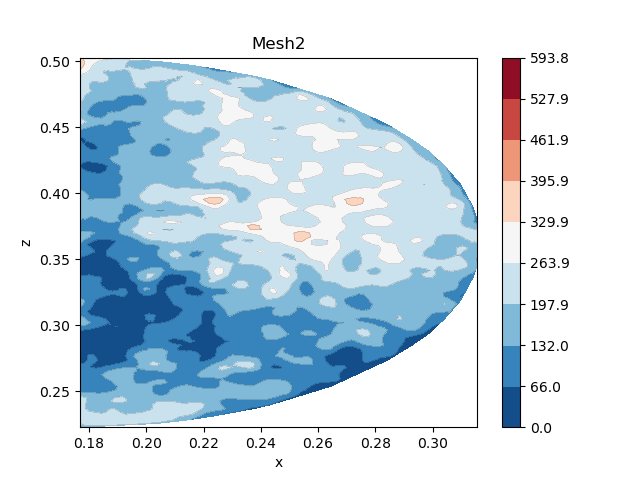

<IPython.core.display.Javascript object>


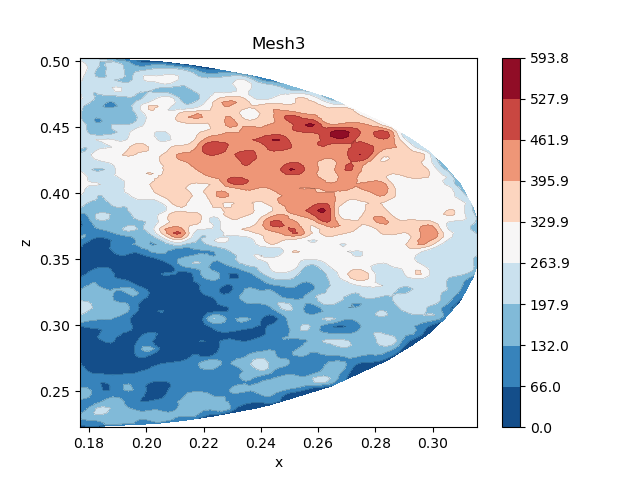

<IPython.core.display.Javascript object>


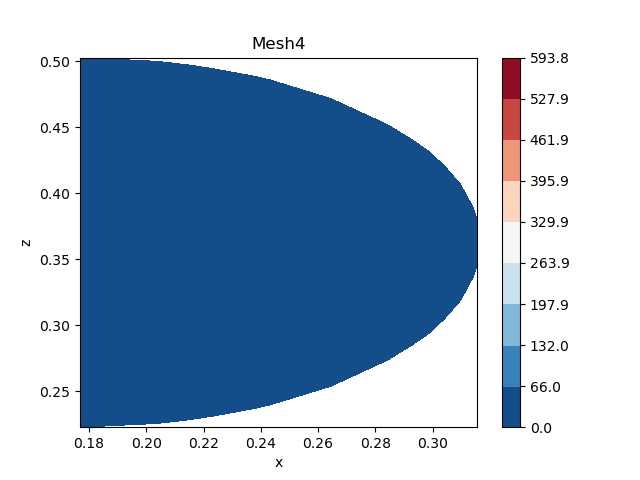

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:28: UserWarning:

No contour levels were found within the data range.



<IPython.core.display.Javascript object>


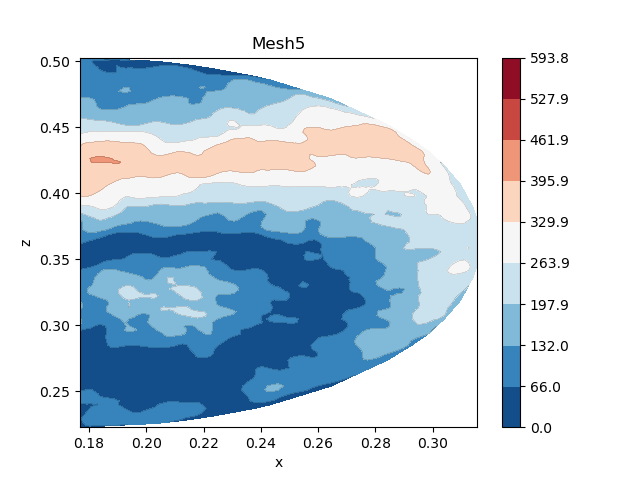

In [14]:
%matplotlib nbagg

level_num = 10

mins = []
maxs= []

for i in range(len(meshes)):
    mesh = meshes[i]
    interpolated_flux[mesh[0]+"SMOOTHEDdiff"] = abs(interpolated_flux[mesh[0]+"SMOOTHED"] - 
                                                    interpolated_flux["Mesh4SMOOTHED"])
    mins.append(min(interpolated_flux[mesh[0]+"SMOOTHEDdiff"]))
    maxs.append(max(interpolated_flux[mesh[0]+"SMOOTHEDdiff"]))

levels = np.linspace(min(mins),max(maxs),level_num)
figs = []

for i in range(len(meshes)):
    mesh = meshes[i]
    figs.append(plt.subplots(nrows=1))
    fig, ax = figs[i]

    x = interpolated_flux['x']
    y = interpolated_flux['z']
    #z = df_combi[' Wall Heat Flux [ W m^-2 ]']
    z = interpolated_flux[mesh[0]+"SMOOTHEDdiff"]

    ax.tricontour(x, y, z, linewidths=0.1, colors='k',levels=levels)
    cntr1 = ax.tricontourf(x, y, z, cmap="RdBu_r", levels=levels)
    fig.colorbar(cntr1, ax=ax)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_title(mesh[0])
plt.show()